In [8]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def generate_contingency_tables(vals):
    tables = np.zeros(shape=(vals.size**4,4));
    i = 0;
    for tp in vals:
        for tn in vals:
            for fp in vals:
                for fn in vals:
                    tables[i] = [tp,tn,fp,fn];
                    i += 1;
    return tables;

In [10]:
def return_ranks(scores_array):
    temp = np.argsort(scores_array)[::-1];

    ranks_array = np.empty(len(scores_array), float);
#   Assigning ranks to the scores according to the order in 'temp' array (descending score)
    ranks_array[temp] = np.arange(len(scores_array));
#   Assigning nan ranks to nan scores
    ranks_array[np.isnan(scores_array)] = np.nan;

    unique, counts = np.unique(scores_array[~np.isnan(scores_array)], return_counts=True);
#     print(unique)

# Handle ties by assigning averaged values to the tied scores
    for idx,u in enumerate(unique):
        ranks_array[scores_array==u] = ranks_array[scores_array==u].sum()/counts[idx];
    return ranks_array

In [11]:
def recall (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    num = f11;
    den = f11 + f01;
    if den == 0:
        return np.nan;
    else:
        return num/den;
def precision (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    num = f11;
    den = f11 + f10;
    if den == 0:
        return np.nan;
    else:
        return num/den;
confidence = precision;

def mutual_information(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    if f11 != 0 and f00 != 0 and f01 != 0 and f10 != 0:
        MI = f11 * np.log2((f11 * N)/((f11 + f10)*(f11 + f01)))
        + f10 * np.log2((f10 * N)/((f11 + f10)*(f10 + f00))) 
        + f01 * np.log2((f01 * N)/((f01 + f00)*(f11 + f01)))
        + f00 * np.log2((f00 * N)/((f01 + f00)*(f10 + f00)));
        return MI/N;
    else:
        return np.nan;

def jaccard (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    if (f11 + f10 + f01) == 0:
        return np.nan;
    else:
        J = f11 / (f11 + f10 + f01);
        return J;

def f_measure (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;

    if f11 == 0:
        return np.nan;
    else:
    #     P_(a given b)
        P_agb = f11 / (f11 + f01);
    #     P_(b given a)
        P_bga = f11 / (f11 + f10);

        FM = (2*P_agb*P_bga) / (P_agb + P_bga);
        return FM;
    
def odds_ratio(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    OR = (f11 * f00)/(f01 * f10);
    return OR;

def specificity(contingency_table):
    f11 = contingency_table[0];
#     f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    den = f00 + f01;
    if den != 0:
        return f00/den;
    else:
        return np.nan;
negative_reliability = specificity;

def sebag_schoenauer(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    if f10:
        return f11/f10;
    else:
        return np.nan;
def accuracy(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    if N:
        return (f11 + f00)/N;
    else:
        return np.nan;
    
def support(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    return f11/N;

def confidence_causal(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    CC = (f11/(f11+f10)) + (f00/(f00+f10));
    return CC/2;

def lift(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    return (f11 * N)/((f11 + f10) * (f11 + f01));

def ganascia(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
#     f01 = contingency_table[2];
#     f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    G = (f11 - f10) / (f11 + f10);
    return G;

def kulczynsky_1 (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
#     f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    K = f11 / (f10 + f01);
    return K;

def coverage(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    return (f11 + f10)/N;

def prevalence(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    return (f11 + f01)/N;

def relative_risk(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    RR = (f11 * (f01 + f00)) / (f01 * (f11 + f10));
    return RR;

def piatetsky_shapiro(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    P_ab = f11/N;
    P_a = (f11 + f10)/N;
    P_b = (f11 + f01)/N;
    return P_ab - P_a*P_b;
novelty = piatetsky_shapiro;

def yules_q(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    YQ = (f11*f00 - f10*f01)/(f11*f00 + f10*f01);
    return YQ;

def yules_y(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    YY = (np.sqrt(f11*f00) - np.sqrt(f10*f01))/(np.sqrt(f11*f00) + np.sqrt(f10*f01));
    return YY;

def cosine(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    cosine = f11 / np.sqrt((f11 + f01)*(f11 + f10));
    return cosine;

def least_contradiction(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    LC = (f11 - f10) / (f11 + f01);
    return LC;

def odd_multiplier(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    OM = (f11 * (f00 + f10))/(f10 * (f11 + f01));
    return OM;

def confirm_descriptive(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    CD = (f11 - f10)/N;
    return CD;

def confirm_causal(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    CC = (f11 + f00 - 2*f10)/N;
    return CC;

def certainty_factor(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    CF = 1 - (f10 * N)/((f11 + f10)*(f00 + f10));
    return CF;
loevinger = certainty_factor;

def conviction(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    conviction = ((f11 + f10)*(f00 + f10))/(f10 * N);
    return conviction;

def information_gain(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    
    IG = np.log2(f11/((f11 + f10)*(f11 + f01)));
    return IG;

def laplace_correction(contingency_table):
    k = 2;
    f11 = contingency_table[0];
    f10 = contingency_table[1];
#     f01 = contingency_table[2];
#     f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    LC = (f11 + 1) / (f11 + f10 + k);
    return LC;

def klosgen(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    P_a = (f11 + f10)/N;
    P_b = (f11 + f01)/N;
    KL = np.sqrt(P_a) * ((f11/(f11 + f10)) - P_b);
    return KL;

def zhang(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    P_a = (f11 + f10)/N;
    P_b = (f11 + f01)/N;
    P_ab = f11/N;
    den_1 = P_ab * (1 - P_b);
    den_2 = P_b * (P_a - P_ab);
    if den_1 > den_2:
        ZH = (P_ab - P_a * P_b)/den_1;
    else:
        ZH = (P_ab - P_a * P_b)/den_2;
    return ZH;

In [15]:
def compute_scores(scores, contingency_tables):
# idxt - index of a contingency table
    for idxt,table in enumerate(contingency_tables):
        scores[idxt,0] = recall(table);
        scores[idxt,1] = precision(table);
        scores[idxt,2] = confidence(table);
        scores[idxt,3] = mutual_information(table);
        scores[idxt,4] = jaccard(table);
        scores[idxt,5] = f_measure(table);
        scores[idxt,6] = odds_ratio(table);
        scores[idxt,7] = specificity(table);
        scores[idxt,8] = negative_reliability(table);
        scores[idxt,9] = sebag_schoenauer(table);
        scores[idxt,10] = accuracy(table);
        scores[idxt,11] = support(table);
        scores[idxt,12] = confidence_causal(table);
        scores[idxt,13] = lift(table);
        scores[idxt,14] = ganascia(table);
        scores[idxt,15] = kulczynsky_1(table);
        scores[idxt,16] = coverage(table);
        scores[idxt,17] = prevalence(table);
        scores[idxt,18] = relative_risk(table);
        scores[idxt,19] = piatetsky_shapiro(table);
        scores[idxt,20] = novelty(table);
        scores[idxt,21] = yules_q(table);
        scores[idxt,22] = yules_y(table);
        scores[idxt,23] = cosine(table);
        scores[idxt,24] = least_contradiction(table);
        scores[idxt,25] = odd_multiplier(table);
        scores[idxt,26] = confirm_descriptive(table);
        scores[idxt,27] = confirm_causal(table);
        scores[idxt,28] = certainty_factor(table);
        scores[idxt,29] = loevinger(table);
        scores[idxt,30] = conviction(table);
        scores[idxt,31] = information_gain(table);
        scores[idxt,32] = laplace_correction(table);
        scores[idxt,33] = klosgen(table);
        scores[idxt,34] = zhang(table);
    return scores;


def compute_ranks(ranks, scores):
    for idx,score in enumerate(scores.T):
    #     print(score)
        ranks[:,idx] = return_ranks(score);
    return ranks;

In [16]:
def show_rank_correlation_matrix(ranks_matrix):
    dist_spearman = spearmanr(ranks_matrix);
    sns.heatmap(dist_spearman.correlation, vmin=0, vmax=1, cmap='YlGnBu');
    plt.show()

def show_ranks_dendrogram(ranks_matrix):
    Y = pdist(ranks_matrix.T, 'correlation');
    Z = hierarchy.linkage(squareform(Y), method='complete');
    hierarchy.dendrogram(Z, orientation='right')
    plt.show()

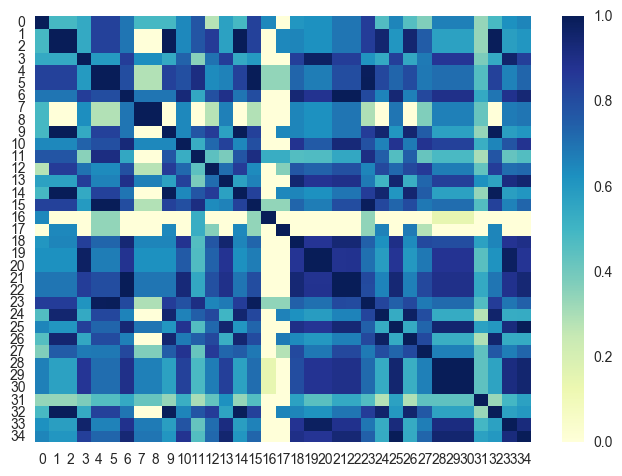

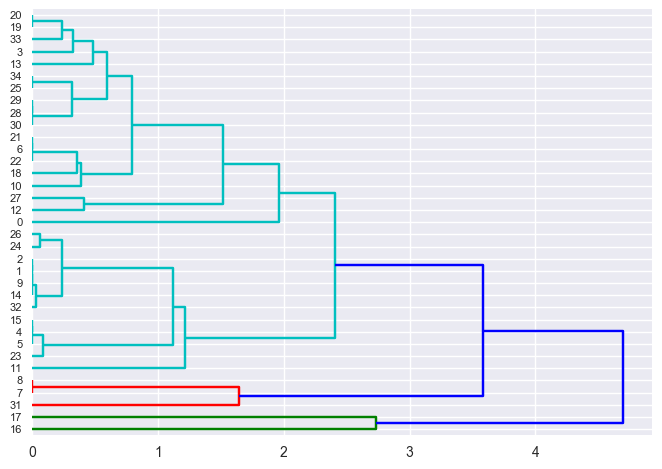

In [17]:
vals = np.array([1,2,11,100,1000,10000]);
tables = generate_contingency_tables(vals);

scores_matrix = np.zeros(shape=(1296,35));
scores_matrix = compute_scores(scores_matrix, tables);

ranks = np.zeros(shape = scores_matrix.shape)
ranks = compute_ranks(ranks, scores_matrix);

show_rank_correlation_matrix(ranks);
show_ranks_dendrogram(ranks);